# Imports

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans, AgglomerativeClustering, FeatureAgglomeration
from scipy.spatial import distance
import matplotlib.pyplot as plt
from embedding_functions_hugo.embedding_functions import *

# Data Grabbing

In [2]:
# subreddit dataframes with comments
df_gaming = pd.read_csv('../data/scrapes/gaming.csv')
df_satis = pd.read_csv('../data/scrapes/SatisfactoryGame.csv')
df_marauders = pd.read_csv('../data/scrapes/MaraudersGame.csv')
df_tarkov = pd.read_csv('../data/scrapes/EscapefromTarkov.csv')
df_politics = pd.read_csv('../data/scrapes/politics.csv')

# loading embeddings
politics_embeddings = np.load('../data/embeddings/politics_embeddings.npy')
gaming_embeddings = np.load('../data/embeddings/gaming_embeddings.npy')
marauders_embeddings = np.load('../data/embeddings/marauders_embeddings.npy')
tarkov_embeddings = np.load('../data/embeddings/tarkov_embeddings.npy')
satisfactory_embeddings = np.load('../data/embeddings/satisfactory_embeddings.npy')

# loading large embeddings
politics_embeddings_large = np.load('../data/big_embeddings/politics.npy')
gaming_embeddings_large = np.load('../data/big_embeddings/gaming.npy')
tarkov_embeddings_large = np.load('../data/big_embeddings/Tarkov.npy')
marauders_embeddings_large = np.load('../data/big_embeddings/Marauders.npy')
satisfactory_embeddings_large = np.load('../data/big_embeddings/Satisfactory.npy')

# Functions

In [3]:
# shortening and cleaning function
def shorten_and_clean_dataset (comment_csv, comment_column : str, desired_comment_length : int):
    dataframe = pd.read_csv(comment_csv)
    dataframe['cleaned_text'] = prep_pipeline(dataframe, comment_column)
    dataframe['short'] = shorten_sens(dataframe['cleaned_text'], desired_comment_length)
    return dataframe

# function for creating and saving embeddings
def save_embeddings_as_npy(destination_path : str, comment_csv, comment_column : str, desired_comment_length : int):
    '''
    Nlp pipeline function which takes a pandas dataframe and relevant columns, performs preprocessing steps, uses sentence_transformer embeddings and saves the embeddings as a csv file.
    '''
    sentences = shorten_and_clean_dataset(comment_csv, comment_column, desired_comment_length)
    embeddings = embed_comments(sentences['short'])
    return np.save(destination_path, embeddings)

def pair_users_embeddings(dataframe, embeddings, average_out_comments = False):
    usernames = dataframe['comment_author']
    user_dictionary = {}
    for author, embedded_comment in zip(usernames, embeddings):
        if author not in user_dictionary.keys():
            user_dictionary[author] = []
            user_dictionary[author].append(embedded_comment)
        else:
            user_dictionary[author].append(embedded_comment)
    if average_out_comments:
        for user in user_dictionary:
            number_or_comments = len(user_dictionary[user])
            user_dictionary[user] = sum(user_dictionary[user])/number_or_comments
    return user_dictionary

# Other prep

## Adding Cleaned Comments

In [4]:
df_politics['cleaned_text'] = prep_pipeline(df_politics, 'comment_text', loud=False)
df_politics['short'] = shorten_sens(df_politics['cleaned_text'], 50)

df_gaming['cleaned_text'] = prep_pipeline(df_gaming, 'comment_text', loud=False)
df_gaming['short'] = shorten_sens(df_gaming['cleaned_text'], 50)

df_tarkov['cleaned_text'] = prep_pipeline(df_tarkov, 'comment_text', loud=False)
df_tarkov['short'] = shorten_sens(df_tarkov['cleaned_text'], 50)

df_marauders['cleaned_text'] = prep_pipeline(df_marauders, 'comment_text', loud=False)
df_marauders['short'] = shorten_sens(df_marauders['cleaned_text'], 50)

df_satis['cleaned_text'] = prep_pipeline(df_satis, 'comment_text', loud=False)
df_satis['short'] = shorten_sens(df_satis['cleaned_text'], 50)

# Comment Inspection

## Quick Prep (r/politics)

In [5]:
politics_user_embeddings = pair_users_embeddings(df_politics, politics_embeddings, True)

# Set PCA to desired number of dimensions
pca = PCA(n_components=2)

pca_embeddings = pca.fit_transform(list(politics_user_embeddings.values()))

kmeans = KMeans(n_clusters=2, random_state=0)

classes = kmeans.fit_predict(pca_embeddings)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Horizontally distant

In [6]:
#print(pca_embeddings.shape)
#print(len(politics_user_embeddings.keys()), len(politics_user_embeddings.values()))

# finding indexes of rows with least and max x values

x_vals = []
for idx, row in enumerate(pca_embeddings):
    x_val = row[0]
    x_vals.append(x_val)

# least x
least_x = min(x_vals)
least_x_index = np.argmin(x_vals)
least_x_username = list(politics_user_embeddings.keys())[least_x_index]
least_x_comments = df_politics.loc[df_politics['comment_author'] == least_x_username]

max_x = max(x_vals)
max_x_index = np.argmax(x_vals)
max_x_username = list(politics_user_embeddings.keys())[max_x_index]
max_x_comments = df_politics.loc[df_politics['comment_author'] == max_x_username]

#print(least_x, least_x_index, least_x_username)
#print(max_x, max_x_index, max_x_username)

#print(df_politics.shape)
#print(len(politics_user_embeddings.keys()))
print('===== Lowest x coord comment =====')
print(least_x_comments['comment_text'].values[0])
print('\n===== Highest x coord comment =====')
print(max_x_comments['comment_text'].values[0])

===== Lowest x coord comment =====
Love how the GOP rails against the illegals coming in and yet this mother fucker has been in the US illegally for 15 years, cannot even vote in US elections and tried to assassinate the Speaker of the House. But the Mexicans…right. So illegals bad when they’re brown but when they’re delusional Canadian psychos who are white….it’s all good.

===== Highest x coord comment =====
That's it?


## Vertically distant

In [7]:
#print(pca_embeddings.shape)
#print(len(politics_user_embeddings.keys()), len(politics_user_embeddings.values()))

# finding indexes of rows with least and max y values

y_vals = []
for idx, row in enumerate(pca_embeddings):
    y_val = row[1]
    y_vals.append(y_val)

# least y
least_y = min(y_vals)
least_y_index = np.argmin(y_vals)
least_y_username = list(politics_user_embeddings.keys())[least_y_index]
least_y_comments = df_politics.loc[df_politics['comment_author'] == least_y_username]

max_y = max(y_vals)
max_y_index = np.argmax(y_vals)
max_y_username = list(politics_user_embeddings.keys())[max_y_index]
max_y_comments = df_politics.loc[df_politics['comment_author'] == max_y_username]

#print(least_y, least_y_index, least_y_username)
#print(max_y, max_y_index, max_y_username)

#print(df_politics.shape)
#print(len(politics_user_embeddings.keys()))
print('===== Lowest y coord comment =====')
print(least_y_comments['comment_text'].values[0])
print()
print('===== Highest y coord comment =====')
print(max_y_comments['comment_text'].values[0])

===== Lowest y coord comment =====
The equation for automation is very simple

Add up the yearly wage, taxes paid by corp, training, vacation, retirement and you have a good number to start.  At 22 an hour an individual would cos the company approximately $52000.00 year.  If the restaurant is open for 16 hours a day the wage is $104000.00.  This is based on a 2000 hour work year.  40 hours a week for 50 weeks.

A kiosk order station costs about $15000.00.
A line cook robot is less than $150000.00 per unit.
The return on investment is often time less than one year.  

No one will have a job at a fast food restaurant except a person to unload the truck and put the food away.

https://finance.yahoo.com/news/mc-donalds-automated-drive-thru-is-just-the-latest-sign-of-robots-taking-over-fast-food-170158300.html

This guy is going to get a bonus for automating the restaurants.

Here is a fully automated McDonalds

https://www.reddit.com/r/Damnthatsinteresting/comments/10odp8f/a_mcdonalds_loca

## Most distant (in progress)

In [8]:
def most_distant(df, embeddings, n=3, large_embeds=True):
    '''
    inputs:
     - df: df to work with
     - embeddings: embeddings to work with
     - n: number of most distant user-pairs to print
    
    Function calculates the distance between all user pairs and sorts them from most to least distant.
    n number of user-pairs have their comments printed
    '''
    
    ### TODO DONT USE pair_users_embeddings
    # # pairing embeddings
    # user_embeddings = pair_users_embeddings(df, embeddings, False)
    
    # # doing pca things
    # pca = PCA(n_components=2)
    # pca_embeddings = pca.fit_transform(list(user_embeddings.values()))

    # looping through dataframe and embeddings to get username list that matches index-wise
    # for embeddings that include every comment (duplicate authors):
    if large_embeds == False:
        username_list = list(df['comment_author'])
    # for embeddings that have averaged authors (no duplicate authors):
    else:
        username_list = list()
        for index, row in df.iterrows():
            username = row['comment_author']
            if username not in username_list:
                username_list.append(username)
    
    # getting user pairs
    pair_dict = dict()
    for i, j in zip(username_list, embeddings):
        pair_dict[i] = j
    
    # reducing embeddings to 2 dimensions
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(list(pair_dict.values()))

    # classifying using kmeans and printing blob
    kmeans = KMeans(n_clusters=2, random_state=0)
    classes = kmeans.fit_predict(pca_embeddings)
    label_color_map = {0 : 'r',1 : 'g'}
    label_color = [label_color_map[l] for l in classes]
    plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=label_color)
    
    distance_list = list() # list for keeping track of maximum distances, index matches the user the distance is from
    distance_to_whom_list = list() # list for keeping track of the index of the user the distance is to
    
    num_rows = pca_embeddings.shape[0]
    print(f'looping through {num_rows} rows, this may take a few mins...')
    
    # looping through embeddings to loop through users
    for idx_a, row_a in enumerate(pca_embeddings):
        x_val_a = row_a[0]
        y_val_a = row_a[1]
        
        max_distance = 0.0
        to_whom_index = 0
        for idx_b, row_b in enumerate(pca_embeddings):
            x_val_b = row_b[0]
            y_val_b = row_b[1]
            
            # calculating euclidean distance
            a = (x_val_a, y_val_a)
            b = (x_val_b, y_val_b)
            dist = distance.euclidean(a, b)
            
            # saving to distance_list and distance_to_whom_list
            if dist > max_distance:
                max_distance = dist
                to_whom_index = idx_b
        
        distance_list.append(max_distance)
        distance_to_whom_list.append(to_whom_index)
    
    # sorting distance_list
    top_n_distances = np.sort(distance_list)
    top_n_indexes = np.argsort(distance_list)[-n:]
    
    #print(top_n_distances)
    #print(top_n_indexes)
    
    n_pairs = dict()
    for a_idx in top_n_indexes:
        n_pairs[a_idx] = [distance_to_whom_list[a_idx], top_n_distances[a_idx]]
    
    #print(n_pairs)
    
    # gettings comments of pairs and printing them
    usernames_a = list()
    for index in n_pairs.keys():
        username = username_list[index]
        usernames_a.append(username)
    
    usernames_b = list()
    for index in list(n_pairs.values()):
        username = username_list[index[0]]
        usernames_b.append(username)
    
    for pair in zip(usernames_a, usernames_b):
        username_a = pair[0]
        username_b = pair[1]
        
        comments_a = df.loc[df['comment_author'] == username_a]
        comments_b = df.loc[df['comment_author'] == username_b]
        
        print(f'\n===== Pair between {username_a} and {username_b} =====')
        print(f' == {username_a}:\n{comments_a["short"].values[0]}')
        print(f' == {username_b}:\n{comments_b["short"].values[0]}')
    
    return

In [9]:
print(df_satis.loc[df_satis['comment_author'] == 'Hob_O_Rarison']['comment_text'].values[0])
print(df_satis.loc[df_satis['comment_author'] == 'Hob_O_Rarison']['short'].values[0])

Dyson Sphere Project + Norm Mcdonald Has A Show.

I have no idea what that is, like one of those weird 3-colored basket balls, which is fine now.
dyson sphere project  norm mcdonald has a show

i have no idea what that is like one of those weird 3colored basket balls which is fine now


In [10]:
# pairing embeddings
user_embeddings = pair_users_embeddings(df_satis, satisfactory_embeddings, True)

# doing pca things
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(list(user_embeddings.values()))
kmeans = KMeans(n_clusters=2, random_state=0)
classes = kmeans.fit_predict(pca_embeddings)

print(pca_embeddings[456])
print(pca_embeddings[1435])
print(pca_embeddings[1425])
print(pca_embeddings[2599])
print(pca_embeddings[2322])
print(pca_embeddings[2429])

print(list(user_embeddings.keys())[1435])
print(df_satis.loc[df_satis['comment_author'] == list(user_embeddings.keys())[1435]]['short'].values[0])
print(list(user_embeddings.keys())[1425])
print(df_satis.loc[df_satis['comment_author'] == list(user_embeddings.keys())[1425]]['short'].values[0])
print(list(user_embeddings.keys())[2599])
print(df_satis.loc[df_satis['comment_author'] == list(user_embeddings.keys())[2599]]['short'].values[0])
print(list(user_embeddings.keys())[2322])
print(df_satis.loc[df_satis['comment_author'] == list(user_embeddings.keys())[2322]]['short'].values[0])
print(list(user_embeddings.keys())[2429])
print(df_satis.loc[df_satis['comment_author'] == list(user_embeddings.keys())[2429]]['short'].values[0])

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[16.13652855 -6.54112529]
[-7.08880951 -0.07425036]
[-7.08880951 -0.07425036]
[-7.08880951 -0.07425036]
[-7.08880951 -0.07425036]
[-7.08881018 -0.07425034]
renchiks2001
gives me subnautica vibes i like this
LaurelRaven
looks a lot more like outer worlds but i really like it
OneofLittleHarmony
i sailed the high seas yonder or the years past
madkem1
gifgiphywmkromrtffhpw
Corgi_nator
i know a civil engineer who appreciates  your work


c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


looping through 2752 rows, this may take a few mins...

===== Pair between EBeast99 and No-Name-0815 =====
 == EBeast99:
my wife said that about modern warfare 2 i see you doing the same thing if there is no progress or final objective i do not understand it then she goes and plays roller coaster tycoon for like 5 hours and then is shocked because she never checked her clock
 == No-Name-0815:
yes

===== Pair between Razorray21 and No-Name-0815 =====
 == Razorray21:
my headcanon is the guy that survived in factorio realized how effective it was to turn a planet into a factory and started a company that was basically ficsit then bought by some mega corp to become the ficsit we know today
 == No-Name-0815:
yes

===== Pair between ZackSabbath96 and TheOGPotatoChild =====
 == ZackSabbath96:
same
 == TheOGPotatoChild:
i finally got oil and my dumbass wanted to make smokeless powders so i brought the heavy oil byproduct stuff 2000 meters by pipe and it was horrible

===== Pair between No_Desc

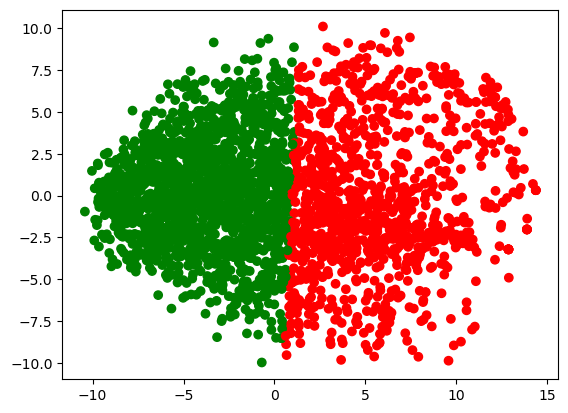

In [11]:
most_distant(df_satis, satisfactory_embeddings_large, n=20, large_embeds=True)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


looping through 10384 rows, this may take a few mins...

===== Pair between Disastrous_Cover6138 and dual_gear =====
 == Disastrous_Cover6138:
yes please
 == dual_gear:
democrats tried to do this a few weeks ago and all the republicans voted against it this is for show obviously due to the name of the bill he did not have the balls to do this when she was speaker there is a poison pill in it so the

===== Pair between YesSkyDaddy and dual_gear =====
 == YesSkyDaddy:
yes please
 == dual_gear:
democrats tried to do this a few weeks ago and all the republicans voted against it this is for show obviously due to the name of the bill he did not have the balls to do this when she was speaker there is a poison pill in it so the

===== Pair between Cute-Curious and dual_gear =====
 == Cute-Curious:
yes please
 == dual_gear:
democrats tried to do this a few weeks ago and all the republicans voted against it this is for show obviously due to the name of the bill he did not have the balls to do th

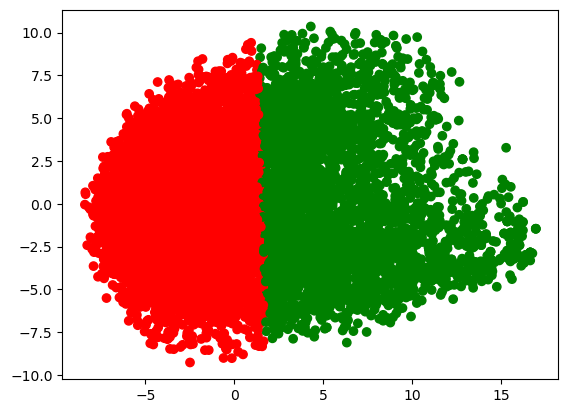

In [12]:
most_distant(df_politics, politics_embeddings_large, n=20)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


looping through 12990 rows, this may take a few mins...

===== Pair between williwaggs and Put_It_All_On_Blck =====
 == williwaggs:
this looks great
 == Put_It_All_On_Blck:
professor oak does not actually expect you to catch all 150 pokemon he is just sending you away on an impossible mission so he can bang your mother who is now home alone for months

===== Pair between afinck01 and Put_It_All_On_Blck =====
 == afinck01:
yes they do
 == Put_It_All_On_Blck:
professor oak does not actually expect you to catch all 150 pokemon he is just sending you away on an impossible mission so he can bang your mother who is now home alone for months

===== Pair between ralphfee and Put_It_All_On_Blck =====
 == ralphfee:
right on 
 == Put_It_All_On_Blck:
professor oak does not actually expect you to catch all 150 pokemon he is just sending you away on an impossible mission so he can bang your mother who is now home alone for months

===== Pair between Fruitbat3 and LoSouLibra =====
 == Fruitbat3:
ok
 

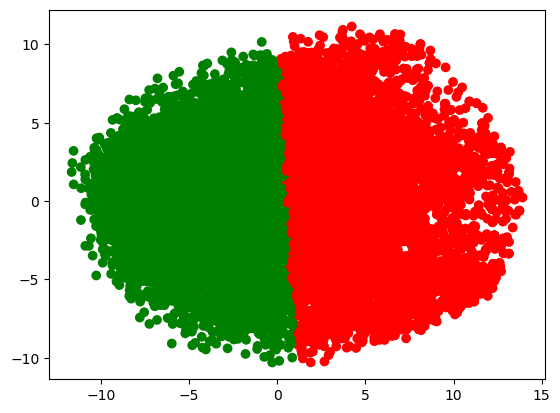

In [13]:
most_distant(df_gaming, gaming_embeddings_large, n=20)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


looping through 6201 rows, this may take a few mins...

===== Pair between Okie95 and LocksmithCharming790 =====
 == Okie95:
based
 == LocksmithCharming790:
new players are dying 247 on lighthouse they do not know other player spawns they are just running into your scope the spawn under the helicopter on the street is dumb too you can die there in 5 seconds too

===== Pair between ATrueHunter and LocksmithCharming790 =====
 == ATrueHunter:
based
 == LocksmithCharming790:
new players are dying 247 on lighthouse they do not know other player spawns they are just running into your scope the spawn under the helicopter on the street is dumb too you can die there in 5 seconds too

===== Pair between _Chizz_ and LocksmithCharming790 =====
 == _Chizz_:
based
 == LocksmithCharming790:
new players are dying 247 on lighthouse they do not know other player spawns they are just running into your scope the spawn under the helicopter on the street is dumb too you can die there in 5 seconds too

=====

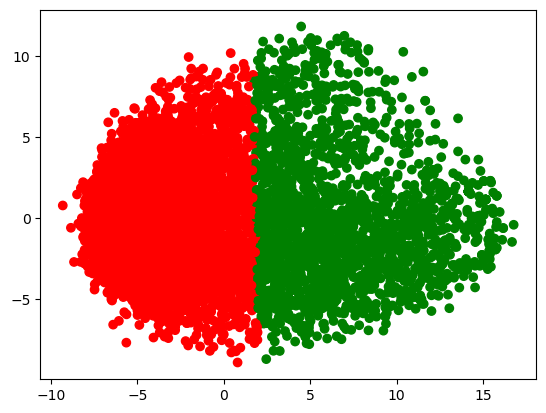

In [14]:
most_distant(df_tarkov, tarkov_embeddings_large, n=20)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


looping through 483 rows, this may take a few mins...

===== Pair between lurowene and maimutadeadlax =====
 == lurowene:
yep quite traumatic your first time then you realize it is a buggy ass game there is no point in having a hoarders stash and gear fear run it down like it is cod go next fast take fights
 == maimutadeadlax:
yes

===== Pair between nsfwysiwyg and maimutadeadlax =====
 == nsfwysiwyg:
now go forth and kill

the opening line of a floating stone effigy head the titular zardoz who just puked a pile of guns for sean connery  friends to use while raping and pillaging to thin the human population what a film
 == maimutadeadlax:
yes

===== Pair between HybridPhoenixKing and maimutadeadlax =====
 == HybridPhoenixKing:
terminator is one of those weapons that is an enigma it supposedly sucks but you are always wary of that guy the one who hunts people with a terminator with zero armor it is goddamn terrifying
 == maimutadeadlax:
yes

===== Pair between Salami__Tsunami and maimut

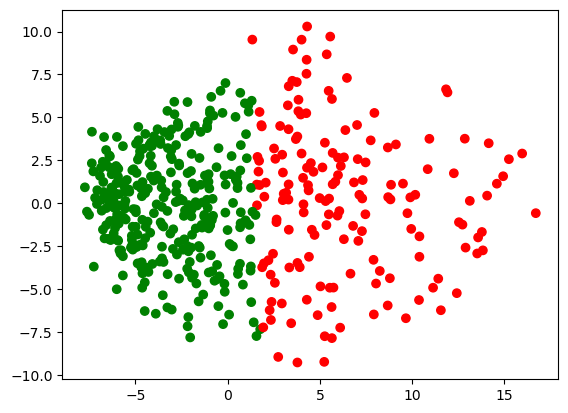

In [15]:
most_distant(df_marauders, marauders_embeddings_large, n=20)

## Similar Comments

In [16]:
def find_similar(df, embeddings):
    '''
    inputs:
     - df: df to work with
     - embeddings: embeddings to work with

    function finds similar groups of users in different areas of the embeddings space and prints one of their comments:
     - MIDDLE: All users around 0 (+/-0.1) are grouped, the amount of users here can vary
     - LEFT, RIGHT, TOP, BOTTOM: For each of these sides 5 users that are the most of them are grouped
    '''
    
    # pairing embeddings
    user_embeddings = pair_users_embeddings(df, embeddings, True)
    
    # doing pca things
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(list(user_embeddings.values()))
    kmeans = KMeans(n_clusters=2, random_state=0)
    classes = kmeans.fit_predict(pca_embeddings)
    
    # print blob
    label_color_map = {0 : 'r',1 : 'g'}
    label_color = [label_color_map[l] for l in classes]
    plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=label_color)
    
    # finding similar things
    # NEED TO CODE FOR FINDING ALL FAR THINGS
    to_check = ['MIDDLE', 'LEFT', 'RIGHT', 'TOP', 'BOTTOM']
    
    for i in to_check:
        
        # finding x and y limits based off of blob
        
        if i == 'MIDDLE':
            print('========== MIDDLE ==========')
            x_lims = [-0.1, 0.1]
            y_lims = [-0.1, 0.1]
            
            similar_indexes = list()
            for idx, row in enumerate(pca_embeddings):
                x_val = row[0]
                y_val = row[1]
                
                if x_val > x_lims[0] and x_val < x_lims[1] and y_val > y_lims[0] and y_val < y_lims[1]:
                    similar_indexes.append(idx)
        
        # checks from far left and finds first 5 comments
        elif i == 'LEFT':
            print('========== LEFT ==========')
            # get list of x coords for sorting
            x_coords = list()
            for idx, row in enumerate(pca_embeddings):
                x_coords.append(row[0])
            
            # sorts x coords by ascending, but gives the indexes not the values
            sorted_indexes = np.argsort(x_coords)
            
            similar_indexes = sorted_indexes[:5]
        
        # checks from far left and finds first 5 comments
        elif i == 'RIGHT':
            print('========== RIGHT ==========')
            # get list of x coords for sorting
            x_coords = list()
            for idx, row in enumerate(pca_embeddings):
                x_coords.append(row[0])
            
            # sorts x coords by descending, but gives the indexes not the values
            initial_sort = np.argsort(x_coords)
            
            similar_indexes = initial_sort[::-1][:5] # 5 for first 5 comments
        
        # checks from far top and finds first 5 comments
        elif i == 'TOP':
            print('========== TOP ==========')
            # get list of y coords for sorting
            y_coords = list()
            for idx, row in enumerate(pca_embeddings):
                y_coords.append(row[1])
            
            # sorts y coords by descending, but gives the indexes not the values
            initial_sort = np.argsort(y_coords)
            
            similar_indexes = initial_sort[::-1][:5] # 5 for first 5 comments
        
        elif i == 'BOTTOM':
            print('========== BOTTOM ==========')
            # get list of y coords for sorting
            y_coords = list()
            for idx, row in enumerate(pca_embeddings):
                y_coords.append(row[1])
            
            # sorts y coords by ascending, but gives the indexes not the values
            sorted_indexes = np.argsort(y_coords)
            
            similar_indexes = sorted_indexes[:5]
            
        # using list of similar indexes, matches with users and prints their comments
        usernames = list()
        for index in similar_indexes:
            username = list(user_embeddings.keys())[index]
            usernames.append(username)

        # cleaning comments to get relevant ones in embedding space
        df['cleaned_text'] = prep_pipeline(df, 'comment_text', loud=False)
        df['short'] = shorten_sens(df['cleaned_text'], 50)
        
        for username in usernames:
            comments = df.loc[df['comment_author'] == username]
            #print(comments['comment_text'].values[0], '\n')
            print(f'{username}:')
            print(comments['short'].values[0], '\n')

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


========== MIDDLE ==========
Whosebert:
fascists this will show those snowflake dems

reasonable citizens we want this too

fascistsshit shit nevermind gdhhds 

Independent_Prune_35:
what another lie good luck with that he will claim to have a disability and will sue you under the disabilities act for discrimination 

Skastrik:
wonder what they will do when they realize his name is not george santos at all 

Ausgezeichnet87:
republican blew 20 trillion on blowing up greatest of all time farmers in the middle east and now they are acting like the government is too broke pay our bills  invest in infrastructure or anything that helps workers


it is all part of their starve the beast strategy 

========== LEFT ==========
fistofthefuture:
fuck this guy but i will take his bill 

tacticalcop:
good now get rid of him 

Picasso5:
it is easy to dismiss these guys as stupid or crazy most likely both but the problem is these guys exist a lot of them so when they turn on right wing radio watch fo

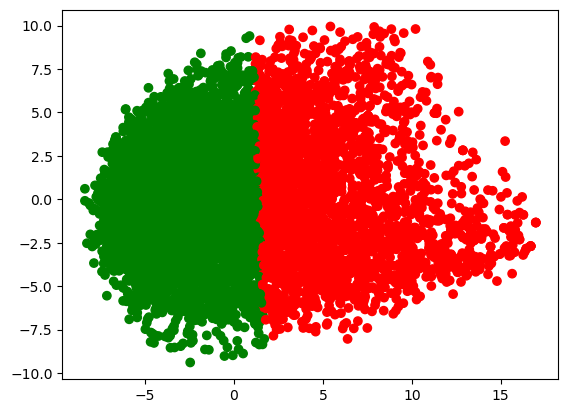

In [17]:
find_similar(df_politics, politics_embeddings_large)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


========== MIDDLE ==========
Uik44:
still in college at 31 what are you studying 

========== LEFT ==========
Reis-iBuca:
i am here before the  award 

pseudoimpossibility:
i cannot see shit 

masterlight123:
this motherfucker just went to google and searced up meme 

OzairBoss:
disgaea has entered the chat 

mavrc:
sooooo how is the difficulty level i am not very good 

========== RIGHT ==========
Mokari_Onedge:
it reminds me of me preparing a university exam and forgetting about the other 

SkoomaJunki3:
meh that is pretty distracting i am going to 

Krakulpo:
you made the average scottish football fan 

wright007:
for a second i thought you were referring to clippy and i was like did clippy really teach us anything 

stash3630:
best assassins creed by a nautical mile 

========== TOP ==========
polishlastnames:
my favorite was the bullet point they used to put on a lot of help articles

google it 

Legion2567:
that is because you have not played lost odyssey it is a crucial entry to

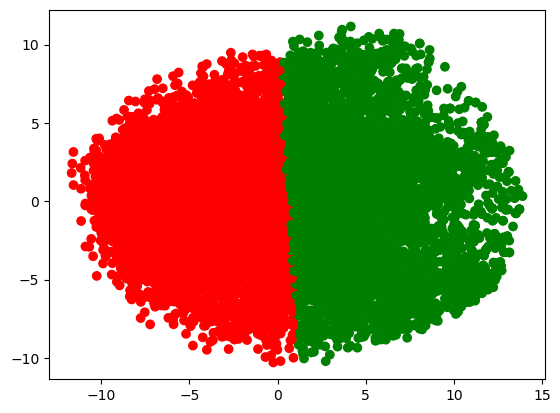

In [18]:
find_similar(df_gaming, gaming_embeddings_large)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


========== MIDDLE ==========
========== LEFT ==========
scared_star:
rip i liked that shotgun even before it was broken 

giacomopica:
man good to hear you are taking care of your health first marauders has also become one of my top games and while it is super fun it stresses me out more than any other game even tarkov somehow anyways good luck friend 

Beast_Mastese:
i am still out there every day giving you guys marauder kills 

JohnnyMcMoney:
yeah my thoughts for 1500 hrs of tarkov as well 

thelostandfound618:
1010 update keep it going guys 

========== RIGHT ==========
dge001:
checkout the death certificate  on  deathverse let ut die it died with in the week of release  less than 100 

Realist419:
more bumping than ever in my humble opinion the only thing that keeps dying is me 

waylonhall21:
it is that capital ship the one with all the commandos on it because i just call it the commando ship laugh my ass off 

xXRazihellXx:
yeah those are fast releif faster than liquigel 

Amigo

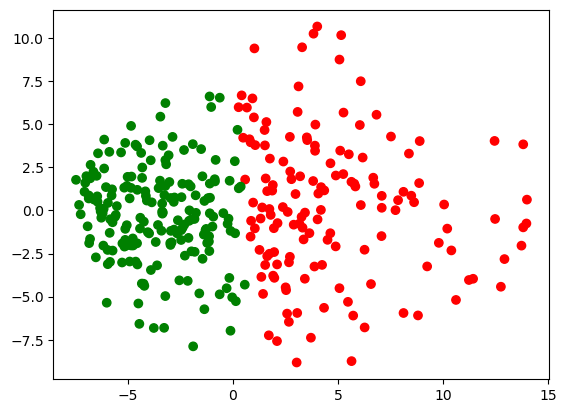

In [19]:
find_similar(df_marauders, marauders_embeddings_large)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


========== MIDDLE ==========
p4nnus:
there is hackers in every raid1 me and my 3 man just got all head eyesd withing 4s fuck this do something bsg 

========== LEFT ==========
Turok36:
cringe 

regularknight:
you see if you fold them a certain way you can fit so many 

RainingBlood78:
i laughed so much man oh my god 

jabralta:
guess what people will still play even bought a nioce after the lip smack sound laptop to play on the road in my sleeper berth so you chumps cannot out level me supply and demand you cannot get this kind of hit anywhere else its cool find the new items 

usprocksv2:
if you die in a suspicious way whatsoever would you report the person killing you  yes or no that is as basic of a question i can ask 

========== RIGHT ==========
Cryovers:
this is 100 offline raid  no other scavsbesides 1 or pmcs around laughing out loud 

Jaysterlo_:
cheater problem aside this is fucking hilarious 

BurgerChurger69:
exit camp factory with impacts 

Novel-Structure8660:
i think you

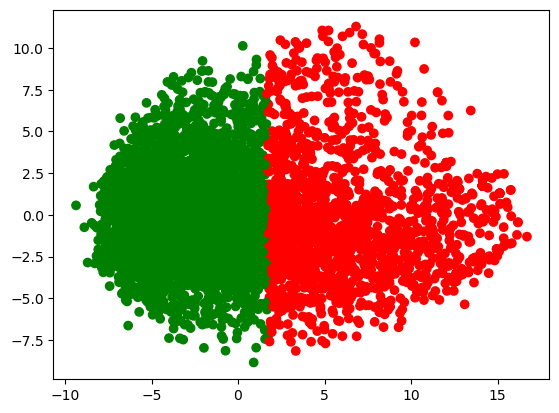

In [20]:
find_similar(df_tarkov, tarkov_embeddings_large)

c:\Users\aidan\anaconda3\envs\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


========== MIDDLE ==========
jonnyfisch:
better game performance i hate the lag spikes when chunks render 

========== LEFT ==========
Roseknight888:
i would say an hour a day would be a perfectly reasonable game play loop though spend an hour setting up or polishing a production line or spend an hour exploring to find some resources 

US_Dept_of_Defence:
when you have not logged in a hot minute and realize you were in the middle of fixing your spaghetti overwhelmed you decide to log off and leave that for the next time 

Hera_the_otter:
remember there are no labor laws or unions in space 

Acrobatic-Truth:
those who click play but never launch the game due to shit pc 

TobbieDatBoi:
looks amazing man straight outta the future 

========== RIGHT ==========
Huntyoudownn:
almost tempted to rebuy it just so i can rid my pc of epic games launcher once and for all 

MinaLamia:
i have taken notes for three games satisfactory stardew and shadow empire

kind of weird they all start with s 

Ob

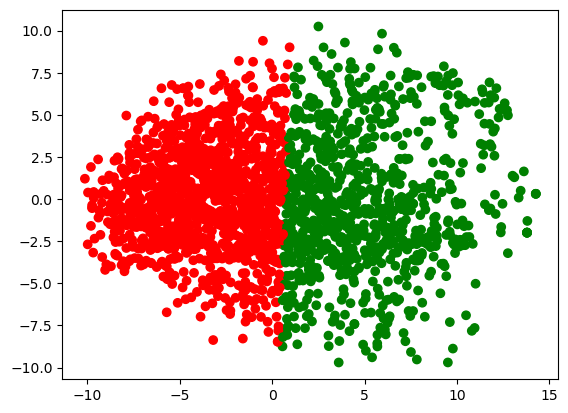

In [21]:
find_similar(df_satis, satisfactory_embeddings_large)